# <center> ICA and Cocktail problem </center>

We will implement three algorithm for Independent Components Analysis to extract source audio files mixed in the files mix[1-9].wav

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (17.0, 5.0)
matplotlib.rcParams['font.size'] = 15

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Imports

### Load the mixed audio files

In [2]:
datasrc = np.empty([9, 50000], np.float32)
for i in range(9):
    fs, datasrc[i,] = wavfile.read('./source' + str(i+1) + '.wav')

In [3]:
fs

8000

### Display audio data

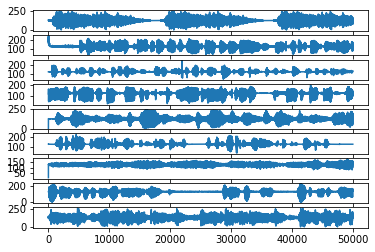

In [4]:
for i in range(9):
    plt.subplot(9, 1, i + 1)
    plt.plot(datasrc[i,])

#### Printing the different input signals

## Mixing our own audio

In [5]:
weights = np.random.rand(2, 2)
if np.linalg.det(weights) == 0:
    print("Error det == 0")
weights

array([[0.14170856, 0.57066612],
       [0.73999745, 0.94469382]])

[[139.54120752 129.12750872 109.87040094 ...  93.17554288  95.87183736
   90.08860977]
 [299.23005176 281.48556556 248.09067716 ... 221.96985492 234.0145105
  189.56754315]]
(50000,)


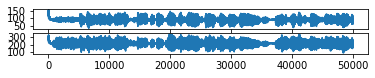

In [6]:
mixed_data = []

"""
for i in range(9):
    if i == 8:
        mixed_data.append(np.dot(weights, [datasrc[8], datasrc[0]]))
    else:
        mixed_data.append(np.dot(weights, [datasrc[i], datasrc[i + 1]]))
"""
mixed_data = weights @ [datasrc[0], datasrc[1]]
print(mixed_data)
for i in range(2):
    plt.subplot(9, 1, i + 1)
    plt.plot(mixed_data[i, :])
print(datasrc[0].shape)

#### I mixed the sources by multiplicating a random 2x2 matrix to obtain sounds mixed 2 by 2 

### Implement the FOBI algorithm and use it to separate the 9 mixed wav files

In [7]:
XC = mixed_data - np.mean(mixed_data, axis=1).reshape(-1, 1)
XC

array([[ 48.33021231,  37.91651352,  18.65940574, ...,   1.96454768,
          4.66084216,  -1.12238543],
       [ 83.84319717,  66.09871097,  32.70382257, ...,   6.58300033,
         18.62765591, -25.81931144]])

#### Centering the data

## Whitening

In [84]:
C = XC @ XC.T
C

array([[22248581.66005188, 26643139.13360755],
       [26643139.13360755, 38211011.06696315]])

#### Whitening the data to take off irrelevant information

In [85]:
val, vec = np.linalg.eigh(C)
B = np.diag(1 / np.sqrt(val)) @ vec.T
B

array([[-5.15985464e-04,  3.84070897e-04],
       [ 7.83732569e-05,  1.05291658e-04]])

#### Computing the eigenvectors and eigenvalues

In [86]:
XB = B @ XC
C1 = XB @ XB.T
C1

array([[1.00000000e+00, 2.88289358e-16],
       [2.88289358e-16, 1.00000000e+00]])

### Compare the error between the original sources and obtained audio files. Listen to the obtained results

In [92]:
norm1 = np.sum(XB * XB, axis=0)
tmp = np.repeat(norm1.reshape((1, -1)), 2, 1).shape
D = (XB * np.ndarray(tmp).reshape(2, 50000)) @ XB.T
D

array([[ 4.57651792e-05, -8.83446611e-07],
       [ 2.56507488e-07,  3.93825795e-05]])

In [95]:
wd, vd = np.linalg.eigh(D)
vd @ np.diag(wd) @ vd.T

array([[4.57651792e-05, 2.56507488e-07],
       [2.56507488e-07, 3.93825795e-05]])

In [96]:
A = vd.T @ C
A

array([[-25729737.04087432, -37112123.66397784],
       [-23298860.070489  , -28153658.8528377 ]])

In [98]:
H = A @ XC
H

array([[-1.40432988e+09, -1.13393578e+09, -5.75617438e+08, ...,
        -3.75343826e+08, -1.19218822e+09,  2.42561874e+09],
       [-1.21066243e+09, -9.75598630e+08, -4.94201364e+08, ...,
        -3.04216201e+08, -9.63476844e+08,  1.94550249e+09]])

In [24]:
import IPython.display as ipd

ipd.Audio(H[1, :], rate=fs)

NameError: name 'H' is not defined

### Implement the FASTICA algorithm and use it to separate the 9 mixed wav files

In [21]:
from math import exp

def FASTica(X, max_iter, tolerance=1e-5):
    """
    :param X: input sources matrix. It is a NxM matrix. Where N is the number of rows corresponding to
              the number of components and M is represents the number of samples for each component.
    :param max_iter: if not converges faster, it will run max_iter steps for each component
    :param tolerance: used to check if two vectors are equal
    :param do_whitening: when True perform the whitening preprocessing
    :param verbose: write to console the progress of the decomposition
    :param dist_fn: distance function between 2 vectors. See metrics module
    :return: S - sources matrix, each row corresponding to a independent component
    """
    # subtract the mean of t to have a centered input matrix
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]

    cov = np.cov(X)

    # Calculate eigenvalues and eigenvectors of the covariance matrix.
    d, E = np.linalg.eigh(cov)

    # Generate a diagonal matrix with the eigenvalues as diagonal elements.
    D = np.diag(d)
    # Inverse of sqrt of D
    Di = np.sqrt(np.linalg.inv(D))

    # Whitening
    X = np.dot(E, np.dot(Di, np.dot(E.T, X)))

    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range(components_nr):  # estimate the i'th component of W
        # starting from an initial random set of weights
        w = np.random.rand(components_nr)
        step_count = 0
        for j in range(max_iter):
            exp = np.exp(- np.power(np.dot(w.T, X), 2) / 2)
            g_der = (1 - np.power(np.dot(w.T, X), 2)) * exp
            g = np.dot(w.T, X) * exp
            w_new = (X * g).mean(axis=1) - g_der.mean() * w

            w_new /= np.sqrt((w_new ** 2).sum())

            if i >= 1:
                # decorrelation of outputs w in order to prevent the new output w to converge
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            # calculate the distance between current w and previous w to check for convergence

            x1=np.abs(w)
            y1=np.abs(w_new)
            dist =  1 - (np.sum(x1 * y1) / (np.sqrt(np.sum(x1 * x1)) * np.sqrt(np.sum(y1 * y1))))
            w = w_new
            if dist < tolerance:
                step_count = j
                break
        W[i, :] = w
    # after calculate the matrix W, the estimated components are obtained by formula W*x
    S = np.dot(W, X)
    return S

### Compare the error between the original sources and obtained audio files. Listen to the obtained results

In [22]:
S = FASTica(mixed_data, 100)

### Compare the three algorithms, results, complexity...

In [25]:
ipd.Audio(S[1, :], rate=fs)

### The decomposition of the sound is better with the FASTica